In [1]:
import pandas as pd
import numpy as np
import recmetrics
import matplotlib.pyplot as plt
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split
import ml_metrics as metrics

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [2]:
ratings = pd.read_csv('data/ml-20m/ratings.csv')
ratings.reset_index(drop=True, inplace=True)
print ratings.shape
ratings.head()

(20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [3]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [4]:
bad_ratings = ratings.query('rating < 3')
bad_ratings = bad_ratings.query('userId in @users')
print bad_ratings.shape
bad_ratings.head(3)

(718132, 4)


,userId,movieId,rating,timestamp
13175,116,2,2.0,1132728068
13176,116,3,2.0,1132728058
13177,116,6,1.5,1132761782


In [5]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(2801066, 4)


,userId,movieId,rating,timestamp
13174,116,1,3.0,1132711617
13175,116,2,2.0,1132728068
13176,116,3,2.0,1132728058


In [6]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

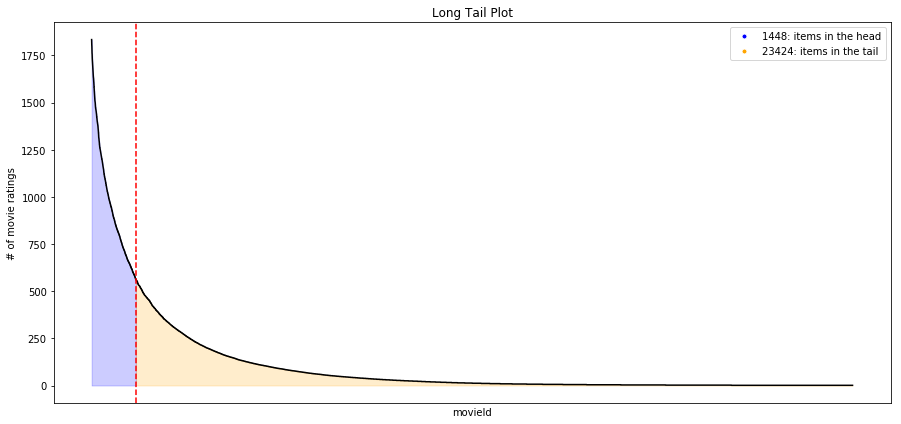

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [8]:
#format data for surprise
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [9]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [85]:
#make predictions on test set. 
#for test we only care about highly rated movies
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,15701,1241,4.5,3.560226
1,74028,4803,3.5,2.884818
2,21163,64957,3.5,2.684344
3,51075,62265,3.5,3.026995
4,43081,1027,4.0,3.726668


In [86]:
#evaluate model with MSE and RMSE
print recmetrics.mse(test.actual, test.cf_predictions)
print recmetrics.rmse(test.actual, test.cf_predictions)

0.5460738201038577
0.738968077865


In [87]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [88]:
#drop bad ratings for movies not in model
movies_in_model = cf_model.columns.tolist()
bad_ratings = bad_ratings.query("movieId in @movies_in_model")

In [89]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist(), recommended_items.predicted_rating.tolist()

In [90]:
#format test data
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})

#make recommendations for all members in the test data
recs = []
rec_scores = []
for user in test.index:
    
    cf_predictions, cf_scores = get_users_predictions(user, 100, cf_model)
    recs.append(cf_predictions)
    rec_scores.append(cf_scores)
        
test['cf_predictions'] = recs
test['cf_scores'] = rec_scores
test.head()

/Users/clongo/Documents/Work/prof_dev/recmetrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,actual,cf_predictions,cf_scores
userId,,,
116,"[256, 33794, 6659, 4100, 40278, 2054, 1032, 10...","[2858, 4878, 33794, 5952, 778, 1884, 223, 5010...","[4.00234333272, 3.84725791712, 3.8402761054, 3..."
156,"[4100, 4103, 2058, 6156, 15, 16, 17, 2067, 411...","[3147, 50, 527, 4014, 4896, 2353, 480, 2396, 2...","[4.94059166536, 4.92334042545, 4.80538293239, ..."
208,"[16, 21, 2076, 29, 32, 6184, 50, 88129, 30812,...","[1204, 1221, 1254, 1214, 2019, 1387, 5291, 114...","[4.6252916421, 4.59356512153, 4.48867384394, 4..."
298,"[1537, 3243, 516, 10, 11, 2572, 3597, 2575, 18...","[2571, 2706, 593, 2335, 1196, 2716, 2840, 104,...","[4.61574229944, 4.50683832039, 4.22621358228, ..."
359,"[2560, 1, 39427, 6149, 37382, 3081, 1546, 7867...","[1198, 318, 912, 1240, 858, 527, 2716, 1304, 2...","[4.71128454848, 4.65138452243, 4.63809812943, ..."


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [91]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,cf_predictions,cf_scores,pop_predictions
userId,,,,
116,"[256, 33794, 6659, 4100, 40278, 2054, 1032, 10...","[2858, 4878, 33794, 5952, 778, 1884, 223, 5010...","[4.00234333272, 3.84725791712, 3.8402761054, 3...","[2571, 356, 1270, 480, 296, 593, 2762, 1580, 1..."
156,"[4100, 4103, 2058, 6156, 15, 16, 17, 2067, 411...","[3147, 50, 527, 4014, 4896, 2353, 480, 2396, 2...","[4.94059166536, 4.92334042545, 4.80538293239, ...","[2571, 356, 1270, 480, 296, 593, 2762, 1580, 1..."
208,"[16, 21, 2076, 29, 32, 6184, 50, 88129, 30812,...","[1204, 1221, 1254, 1214, 2019, 1387, 5291, 114...","[4.6252916421, 4.59356512153, 4.48867384394, 4...","[2571, 356, 1270, 480, 296, 593, 2762, 1580, 1..."
298,"[1537, 3243, 516, 10, 11, 2572, 3597, 2575, 18...","[2571, 2706, 593, 2335, 1196, 2716, 2840, 104,...","[4.61574229944, 4.50683832039, 4.22621358228, ...","[2571, 356, 1270, 480, 296, 593, 2762, 1580, 1..."
359,"[2560, 1, 39427, 6149, 37382, 3081, 1546, 7867...","[1198, 318, 912, 1240, 858, 527, 2716, 1304, 2...","[4.71128454848, 4.65138452243, 4.63809812943, ...","[2571, 356, 1270, 480, 296, 593, 2762, 1580, 1..."


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [92]:
#make recommendations for all members in the test data

recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

,actual,cf_predictions,cf_scores,pop_predictions,random_predictions
userId,,,,,
116,"[256, 33794, 6659, 4100, 40278, 2054, 1032, 10...","[2858, 4878, 33794, 5952, 778, 1884, 223, 5010...","[4.00234333272, 3.84725791712, 3.8402761054, 3...","[2571, 356, 1270, 480, 296, 593, 2762, 1580, 1...","[91529, 2594, 74, 7613, 8983, 98809, 40583, 34..."
156,"[4100, 4103, 2058, 6156, 15, 16, 17, 2067, 411...","[3147, 50, 527, 4014, 4896, 2353, 480, 2396, 2...","[4.94059166536, 4.92334042545, 4.80538293239, ...","[2571, 356, 1270, 480, 296, 593, 2762, 1580, 1...","[4784, 1409, 5293, 3115, 27450, 53125, 80862, ..."
208,"[16, 21, 2076, 29, 32, 6184, 50, 88129, 30812,...","[1204, 1221, 1254, 1214, 2019, 1387, 5291, 114...","[4.6252916421, 4.59356512153, 4.48867384394, 4...","[2571, 356, 1270, 480, 296, 593, 2762, 1580, 1...","[25774, 2007, 427, 2803, 416, 26554, 6158, 433..."
298,"[1537, 3243, 516, 10, 11, 2572, 3597, 2575, 18...","[2571, 2706, 593, 2335, 1196, 2716, 2840, 104,...","[4.61574229944, 4.50683832039, 4.22621358228, ...","[2571, 356, 1270, 480, 296, 593, 2762, 1580, 1...","[1702, 3114, 4285, 77328, 3094, 7354, 6620, 36..."
359,"[2560, 1, 39427, 6149, 37382, 3081, 1546, 7867...","[1198, 318, 912, 1240, 858, 527, 2716, 1304, 2...","[4.71128454848, 4.65138452243, 4.63809812943, ...","[2571, 356, 1270, 480, 296, 593, 2762, 1580, 1...","[3060, 79008, 1352, 442, 3998, 89745, 1391, 52..."


# Mean Average Recall at K

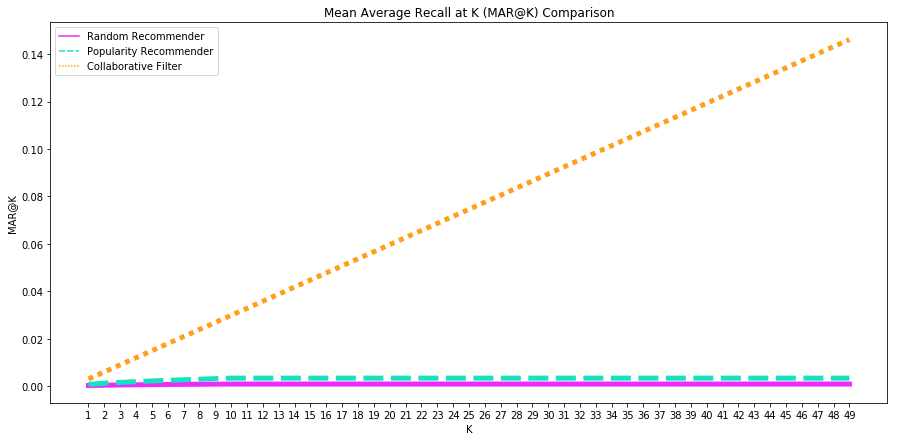

In [116]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

pop_mark = []
for K in np.arange(1, 50):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])

random_mark = []
for K in np.arange(1, 50):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])

cf_mark = []
for K in np.arange(1, 50):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])

mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,50)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

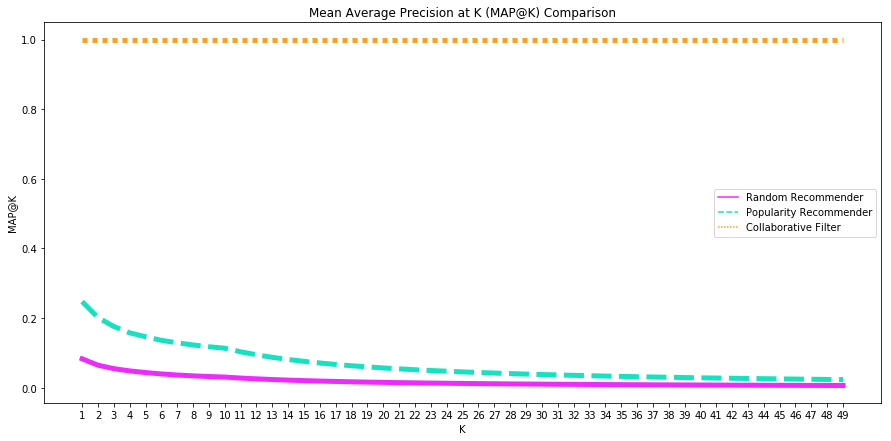

In [115]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

pop_mapk = []
for K in np.arange(1, 50):
    pop_mapk.extend([metrics.mapk(actual, pop_predictions, k=K)])

random_mapk = []
for K in np.arange(1, 50):
    random_mapk.extend([metrics.mapk(actual, random_predictions, k=K)])

cf_mapk = []
for K in np.arange(1, 50):
    cf_mapk.extend([metrics.mapk(actual, cf_predictions, k=K)])

mapk_scores = [random_mapk, pop_mapk, cf_mapk]
index = range(1,50)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mapk_plot(mapk_scores, model_names=names, k_range=index)

# Precision and Recall

You can totally evaluate a recommende system using precison and recall, and it can offer some great insights. 
Because most recommendation use-cases present recommendations as an ordered list, it is still important to evaluate the accuracy of that order. 
The msot relevant items should be at the top. MARP and MAPK evalaut4e the oder of the list. 
However, it is still valuable to look at the precision and recall tradeoff over all recommendationws wihtout considering the order of the list.
Consider a case where you plan to only show the top 5 recommendations on a single page. In that case, order may not matter since the user will see all 5, 
You simply want to make sure all 5 of those items are good. Lookign at the precison and recall tradeoff can do this. 
The procision recall tradeoff will also illustrate the ideal threshold for determining when to recommend an item. 
For example, ig all accurante4 recommendations have a recommended score greater than 3, then you should threshold your recommendations at 3.

In this case, an item is recommended if it has a predicted score greater than 3. 
I am considering class0: movie was not watched, class 1: movie was watched and received a greater than 3 star rating.
This class assignment could be done in any way. Maybe returned items are class 0, and kept items are class 1. or non-clicked linkes are class 0, clicked links are class 1.

The thing that makes recommenders different/special from classical classification is that we don't know anything about the items the that the user did not interact with.
Items that were not interacted with, for example a movie that was not watched, are not nessicarily items we should not recommend. We just don't have any data to test those recommendations against. 
In some cases, you will have some kind of negative feedvbadck like returns or negative revuews, you can construct a class 0 directly with those, and dissregard obervations that have no interactions to test against. 
If you don't have those, keep in mind a high score for an item not interacted with may not be an innacurate recommendation. 

In [78]:
def recommender_precision(predicted, actual): 
    
    def calc_precision(predicted, actual):
        prec = [value for value in predicted if value in actual] 
        prec = np.round(float(len(prec))/float(len(predicted)),4)
        return prec
    
    precision = np.mean(map(calc_precision, predicted, actual))
    return precision

In [79]:
def recommender_recall(predicted, actual): 
    
    def calc_recall(predicted, actual):
        reca = [value for value in predicted if value in actual] 
        reca = np.round(float(len(reca))/float(len(actual)), 4)
        return reca
    
    recall = np.mean(map(calc_recall, predicted, actual))
    return recall

In [80]:
recommender_precision(test.cf_predictions, test.actual)

1.0

In [81]:
recommender_recall(test.cf_predictions, test.actual)

0.04173667728237792

In [82]:
df_scores = pd.DataFrame([])
for user in test.index:
    df_user = pd.DataFrame(cf_model.loc[user])

    #get scores for all movies
    df_user.columns = ["probability"]

    #assign class 0 and class 1
    df_user["truth"] = np.nan
    df_user.loc[test.loc[user].actual, "truth"] = 1
    df_user.loc[bad_ratings.query('userId == @user').movieId.tolist(), "truth"] = 0

    #drop movies that were not interacted with
    df_user.dropna(inplace=True)
    
    df_scores = df_scores.append(df_user)
    

In [83]:
print df_scores.shape
df_scores.head()

(1228680, 2)


,probability,truth
movieId,,
2,0.0,0.0
3,0.0,0.0
6,0.0,0.0
8,0.0,0.0
9,0.0,0.0


LinAlgError: singular matrix

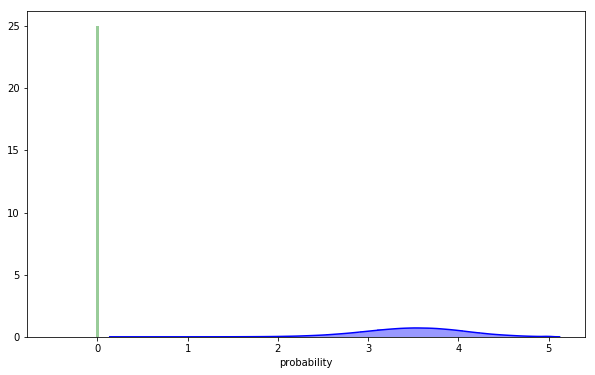

In [84]:
recmetrics.class_separation_plot(df_scores,
                                 threshold=3,
                                 n_bins=25,
                                 class0_label="User rated movie low",
                                 class1_label="User rated movie high")

# Confusion Matrix

In [241]:
import itertools
from sklearn.metrics import confusion_matrix


def make_confustion_matriz(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)*100

    fmt = '.2f'
    thresh = cm.max() / 2.
    descriptions = np.array([["True Positive", "False Negative"], ["False Positive", "True Negatives"]])
    colors = np.array([["green", "red"], ["red", "green"]])
    plt.imshow([[0,0],[0,0]], interpolation='nearest', cmap=plt.cm.Greys)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt)+'%\n' + descriptions[i, j],
                     horizontalalignment="center",
                     color=colors[i,j])
    plt.axhline(y=0.5, xmin=0, xmax=1, color="black", linewidth=0.75)
    plt.axvline(x=0.5, ymin=0, ymax=1, color="black", linewidth=0.75)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.xticks([0,1], [1,0], rotation=45)
    plt.yticks([0,1], [1,0])

    plt.show()

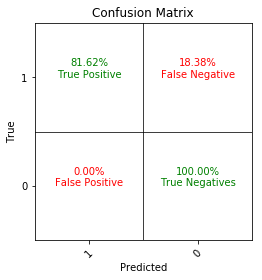

In [242]:
#recommend items with scores greater than 3
df_scores["recommended"] = 0
df_scores.loc[df_scores.probability>3,"recommended"]=1
df_scores.head()

y_true = df_scores.truth
y_pred = df_scores.recommended


make_confustion_matriz(y_true, y_pred)

# Rank Order Analysis 

In [233]:
df_scores.head()

,probability,truth,recommended
movieId,,,
2,0.0,0.0,0
3,0.0,0.0,0
6,0.0,0.0,0
8,0.0,0.0,0
9,0.0,0.0,0


In [ ]:
rank order analysis for recommenders. Predicted score, then % of movies watched by each quantile. 

# Interactions versus precision plot

In [ ]:
How does the value of predictions relaate to # of interactions from the user? Plot precision by #of user-interactions. 

# Popularity Bias

In [ ]:
How popular are the items accuratly recommended